## 1. PPI and GDA data gathering and interactome reconstruction


In [1]:
# Import necessary libraries
import os
import sys
import time
import warnings
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from statistics import mean, stdev
import matplotlib.pyplot as plt
import requests

# Suppress warnings
warnings.filterwarnings("ignore")

### 1.1 Download PPIs 

In [2]:
# Define the path to the BioGRID Tab3 txt file
biogrid_file = 'BIOGRID-ALL-4.4.240.tab3.txt'

# Check if the file exists
if not os.path.exists(biogrid_file):
    print(f"File {biogrid_file} not found. Please ensure the file is in the current directory.")
else:
    print(f"Found BioGRID file: {biogrid_file}")
    
    # Display the first few lines to verify
    with open(biogrid_file, 'r') as file:
        for _ in range(5):
            print(file.readline().strip())


Found BioGRID file: BIOGRID-ALL-4.4.240.tab3.txt
#BioGRID Interaction ID	Entrez Gene Interactor A	Entrez Gene Interactor B	BioGRID ID Interactor A	BioGRID ID Interactor B	Systematic Name Interactor A	Systematic Name Interactor B	Official Symbol Interactor A	Official Symbol Interactor B	Synonyms Interactor A	Synonyms Interactor B	Experimental System	Experimental System Type	Author	Publication Source	Organism ID Interactor A	Organism ID Interactor B	Throughput	Score	Modification	Qualifications	Tags	Source Database	SWISS-PROT Accessions Interactor A	TREMBL Accessions Interactor A	REFSEQ Accessions Interactor A	SWISS-PROT Accessions Interactor B	TREMBL Accessions Interactor B	REFSEQ Accessions Interactor B	Ontology Term IDs	Ontology Term Names	Ontology Term Categories	Ontology Term Qualifier IDs	Ontology Term Qualifier Names	Ontology Term Types	Organism Name Interactor A	Organism Name Interactor B
103	6416	2318	112315	108607	-	-	MAP2K4	FLNC	JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAPKK1

In [3]:
# Open the file and read the header line
with open(biogrid_file, 'r') as file:
    header = file.readline().strip().split('\t')
    print("Header Columns:")
    for idx, col in enumerate(header, start=1):
        print(f"{idx}. {col}")


Header Columns:
1. #BioGRID Interaction ID
2. Entrez Gene Interactor A
3. Entrez Gene Interactor B
4. BioGRID ID Interactor A
5. BioGRID ID Interactor B
6. Systematic Name Interactor A
7. Systematic Name Interactor B
8. Official Symbol Interactor A
9. Official Symbol Interactor B
10. Synonyms Interactor A
11. Synonyms Interactor B
12. Experimental System
13. Experimental System Type
14. Author
15. Publication Source
16. Organism ID Interactor A
17. Organism ID Interactor B
18. Throughput
19. Score
20. Modification
21. Qualifications
22. Tags
23. Source Database
24. SWISS-PROT Accessions Interactor A
25. TREMBL Accessions Interactor A
26. REFSEQ Accessions Interactor A
27. SWISS-PROT Accessions Interactor B
28. TREMBL Accessions Interactor B
29. REFSEQ Accessions Interactor B
30. Ontology Term IDs
31. Ontology Term Names
32. Ontology Term Categories
33. Ontology Term Qualifier IDs
34. Ontology Term Qualifier Names
35. Ontology Term Types
36. Organism Name Interactor A
37. Organism Name 

In [4]:
def process_biogrid_tab3(file_path, chunk_size=50000):
    """
    Process the BioGRID Tab3 file to extract human physical interactions.

    Parameters:
    - file_path: Path to the BioGRID Tab3 txt file.
    - chunk_size: Number of rows per chunk to read.

    Returns:
    - Set of tuples representing filtered interactions.
    """
    # Initialize an empty set to store unique interactions
    interactions = set()

    # Define desired columns as per the Tab3 file
    desired_columns = [
        'Entrez Gene Interactor A', 
        'Entrez Gene Interactor B',
        'Organism ID Interactor A',
        'Organism ID Interactor B',
        'Experimental System Type'
    ]

    # Initialize reader
    try:
        reader = pd.read_csv(
            file_path, 
            sep='\t', 
            chunksize=chunk_size, 
            usecols=desired_columns,
            dtype=str  # Read all as string to handle parsing
        )
    except Exception as e:
        print(f"Error initializing reader: {e}")
        return interactions

    # Process each chunk
    for chunk in tqdm(reader, desc="Processing chunks"):
        try:
            # Replace '-' with NaN
            chunk.replace('-', pd.NA, inplace=True)

            # Drop rows with missing data
            chunk.dropna(subset=desired_columns, inplace=True)

            # Convert IDs and Tax IDs to integers
            chunk['Entrez Gene Interactor A'] = chunk['Entrez Gene Interactor A'].astype(int)
            chunk['Entrez Gene Interactor B'] = chunk['Entrez Gene Interactor B'].astype(int)
            chunk['Organism ID Interactor A'] = chunk['Organism ID Interactor A'].astype(int)
            chunk['Organism ID Interactor B'] = chunk['Organism ID Interactor B'].astype(int)

            # Filter for Homo sapiens (TaxID 9606)
            human_interactions = chunk[
                (chunk['Organism ID Interactor A'] == 9606) & 
                (chunk['Organism ID Interactor B'] == 9606)
            ]

            # Filter for physical interactions
            physical_interactions = human_interactions[
                human_interactions['Experimental System Type'].str.lower() == 'physical'
            ]

            # Iterate through filtered interactions and add to the set
            for _, row in physical_interactions.iterrows():
                gene_a = row['Entrez Gene Interactor A']
                gene_b = row['Entrez Gene Interactor B']

                # Avoid self-loops
                if gene_a != gene_b:
                    # Store as a sorted tuple to avoid duplicate edges (A-B same as B-A)
                    interactions.add(tuple(sorted((gene_a, gene_b))))

            # Display progress
            print(f"Unique interactions so far: {len(interactions)}", end='\r')

        except Exception as e:
            print(f"\nError processing chunk: {e}")
            continue  # Skip to the next chunk in case of error

    print(f"\nTotal unique interactions extracted: {len(interactions)}")
    return interactions


In [5]:
# Process the interactions
interactions = process_biogrid_tab3(biogrid_file)


Processing chunks: 0it [00:00, ?it/s]

Unique interactions so far: 861240
Total unique interactions extracted: 861240


In [6]:
def build_interactome(interactions):
    """
    Build the interactome network and extract the largest connected component.

    Parameters:
    - interactions: Set of tuples representing protein-protein interactions.

    Returns:
    - Largest connected component as a NetworkX graph.
    """
    G = nx.Graph()
    G.add_edges_from(interactions)
    print(f"Total nodes in the network: {G.number_of_nodes()}")
    print(f"Total edges in the network: {G.number_of_edges()}")

    # Extract the Largest Connected Component (LCC)
    if nx.is_connected(G):
        print("The network is fully connected.")
        return G
    else:
        lcc = max(nx.connected_components(G), key=len)
        LCC = G.subgraph(lcc).copy()
        print(f"Largest Connected Component has {LCC.number_of_nodes()} nodes and {LCC.number_of_edges()} edges.")
        return LCC


In [7]:
# Build the interactome network
LCC = build_interactome(interactions)


Total nodes in the network: 19974
Total edges in the network: 861240
The network is fully connected.


In [8]:
print(f"LCC has {LCC.number_of_nodes()} nodes and {LCC.number_of_edges()} edges.")
print(f"Average degree: {sum(dict(LCC.degree()).values()) / LCC.number_of_nodes():.2f}")


LCC has 19974 nodes and 861240 edges.
Average degree: 86.24


In [9]:
def visualize_subgraph(LCC, top_n=100):
    """
    Visualize the top_n nodes by degree in the Largest Connected Component (LCC).
    
    Parameters:
    - LCC: NetworkX graph object representing the Largest Connected Component.
    - top_n: Number of top nodes by degree to include in the visualization.
    """
    # Calculate degrees and sort nodes
    degrees = dict(LCC.degree())
    sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)
    
    # Select top_n nodes
    top_nodes = sorted_nodes[:top_n]
    
    # Create subgraph
    subG = LCC.subgraph(top_nodes).copy()
    
    # Set node size based on degree
    node_sizes = [degrees[node]*10 for node in subG.nodes()]
    
    # Set node color based on degree
    node_colors = [degrees[node] for node in subG.nodes()]
    
    # Choose a different layout for better aesthetics
    pos = nx.kamada_kawai_layout(subG)
    
    plt.figure(figsize=(20, 20))
    nodes = nx.draw_networkx_nodes(
        subG, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        alpha=0.8
    )
    edges = nx.draw_networkx_edges(
        subG, pos,
        alpha=0.5,
        edge_color='gray'
    )
    labels = nx.draw_networkx_labels(
        subG, pos,
        font_size=10,
        font_family='sans-serif'
    )
    
    plt.title(f"Top {top_n} Nodes by Degree in LCC", fontsize=20)
    plt.colorbar(nodes, label='Degree')
    plt.axis('off')
    plt.show()


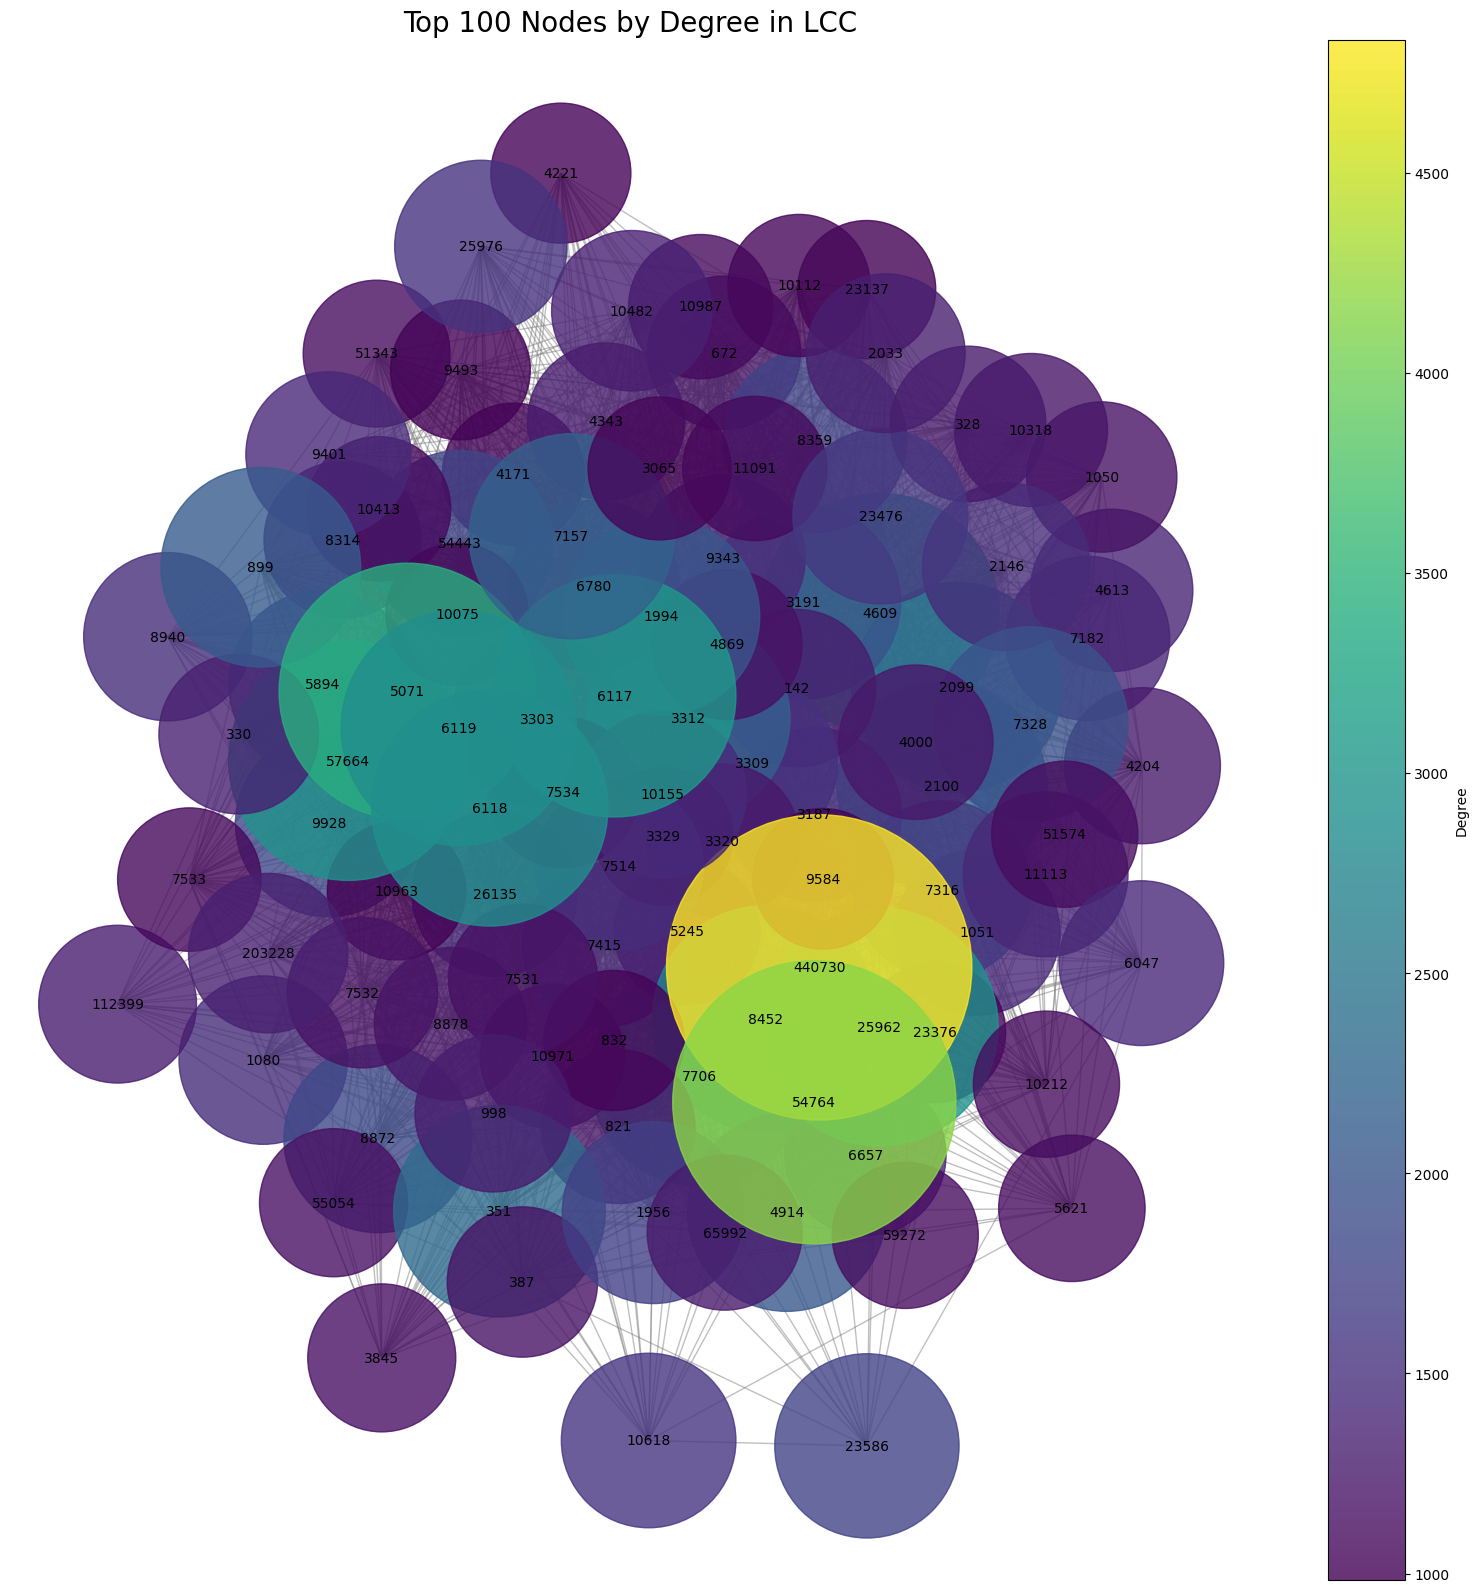

In [10]:
# Call the function to visualize
visualize_subgraph(LCC, top_n=100)


In [11]:
# Save as GraphML
graphml_file = 'Human_Interactome_LCC.graphml'
nx.write_graphml(LCC, graphml_file)
print(f"Largest Connected Component saved to {graphml_file}")

Largest Connected Component saved to Human_Interactome_LCC.graphml


In [12]:
# Example: Load from Pickle
LCC_loaded = nx.read_graphml('Human_Interactome_LCC.graphml')
print(f"Loaded LCC has {LCC_loaded.number_of_nodes()} nodes and {LCC_loaded.number_of_edges()} edges.")


Loaded LCC has 19974 nodes and 861240 edges.


In [13]:
# Sample validation
sample_size = 100
sample_interactions = list(interactions)[:sample_size]

# Re-load the data for these interactions to check 'Interaction Types'
# This requires re-reading the file or maintaining additional data during processing
# Alternatively, ensure your filtering was correct based on known standards

print(f"Sample of {sample_size} interactions:")
for interaction in sample_interactions:
    print(interaction)


Sample of 100 interactions:
(335, 6289)
(1994, 23567)
(970, 23244)
(292, 55611)
(2317, 51547)
(5318, 8165)
(3301, 10592)
(79005, 118490)
(10870, 79956)
(9830, 10456)
(8359, 9444)
(23560, 51187)
(54471, 54764)
(9454, 170680)
(10112, 29767)
(3855, 11151)
(832, 55740)
(55779, 63891)
(7175, 11091)
(170575, 345274)
(5440, 58493)
(5784, 10008)
(9931, 79155)
(56893, 56937)
(2534, 3667)
(1503, 9343)
(1915, 59272)
(27309, 54623)
(10476, 56997)
(9533, 10061)
(1654, 253943)
(8473, 10081)
(3611, 4001)
(9092, 10318)
(4719, 64745)
(6615, 23118)
(6134, 10013)
(2146, 6187)
(2697, 60412)
(1469, 3693)
(29761, 29843)
(8776, 11021)
(932, 3488)
(4223, 5696)
(9928, 55852)
(55662, 55735)
(4154, 121340)
(11198, 115426)
(28976, 55173)
(6421, 406906)
(56001, 84248)
(2331, 6317)
(150771, 255809)
(1406, 55022)
(817, 54627)
(6227, 83732)
(1736, 8359)
(6182, 6647)
(3009, 8632)
(213, 7157)
(891, 3837)
(7186, 79873)
(5455, 6318)
(8766, 9902)
(54963, 252839)
(23233, 149371)
(3998, 6867)
(409, 3312)
(11338, 159163)
(68

### 1.2 Gather gene-disease associations

In [14]:
# Constants
HGNC_API_URL = "https://rest.genenames.org/fetch/"
HEADERS = {'Accept': 'application/json'}

# Function to fetch gene data from HGNC
def fetch_hgnc_data(row):
    """
    Fetch gene data from HGNC using available identifiers.

    Parameters:
        row (Series): A row from the DataFrame containing gene information.

    Returns:
        dict or None: Gene data if found, else None.
    """
    identifiers = {
        'ensembl_gene_id': row['geneEnsemblIDs'],
        'uniprot_ids': row['UnitProt'],
        'entrez_id': str(row['geneNcbiID']),
        'symbol': row['Gene']
    }
    
    for id_type, id_value in identifiers.items():
        if pd.notna(id_value) and id_value:
            ids = [i.strip() for i in str(id_value).split(',')]
            for id_ in ids:
                url = f"{HGNC_API_URL}{id_type}/{id_}"
                response = requests.get(url, headers=HEADERS)
                if response.status_code == 200:
                    data = response.json()
                    if data['response']['numFound'] > 0:
                        return data['response']['docs'][0]
                time.sleep(0.1)  # To respect API rate limits
    return None

# Function to verify gene names
def verify_gene_names(df):
    deviations = []
    verified_rows = []

    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Verifying Gene Names"):
        original_symbol = row['Gene']
        hgnc_data = fetch_hgnc_data(row)
        if hgnc_data:
            hgnc_symbol = hgnc_data['symbol']
            if original_symbol != hgnc_symbol:
                deviations.append({
                    'Original_Gene_Symbol': original_symbol,
                    'HGNC_Symbol': hgnc_symbol,
                    'Ensembl_IDs': row['geneEnsemblIDs'],
                    'UniProt_IDs': row['UnitProt'],
                    'NCBI_ID': row['geneNcbiID'],
                    'Gene_Type': row['geneNcbiType']
                })
                # Update the gene symbol
                row['Gene'] = hgnc_symbol
        else:
            deviations.append({
                'Original_Gene_Symbol': original_symbol,
                'HGNC_Symbol': 'Not Found',
                'Ensembl_IDs': row['geneEnsemblIDs'],
                'UniProt_IDs': row['UnitProt'],
                'NCBI_ID': row['geneNcbiID'],
                'Gene_Type': row['geneNcbiType']
            })
        verified_rows.append(row)

    deviations_df = pd.DataFrame(deviations)
    verified_df = pd.DataFrame(verified_rows)
    return deviations_df, verified_df

def main():
    # Load the TSV file
    df = pd.read_csv('DISEASES_Summary_GDA_CURATED_C0011581.tsv', sep='\t')

    # Verify gene names
    deviations_df, verified_df = verify_gene_names(df)

    # Save deviations to TSV
    deviations_df.to_csv('Gene_Symbol_Deviations.tsv', sep='\t', index=False)
    print(f"Deviations saved to 'Gene_Symbol_Deviations.tsv'")

    # Save verified GDAs
    verified_df.to_csv('Verified_GDAs.tsv', sep='\t', index=False)
    print(f"Verified GDAs saved to 'Verified_GDAs.tsv'")

if __name__ == "__main__":
    main()


Verifying Gene Names:   0%|          | 0/271 [00:00<?, ?it/s]

Deviations saved to 'Gene_Symbol_Deviations.tsv'
Verified GDAs saved to 'Verified_GDAs.tsv'


In [15]:
deviations_df = pd.read_csv('Gene_Symbol_Deviations.tsv', sep='\t')
display(deviations_df.head(10))  # Display first 10 deviations


,Original_Gene_Symbol,HGNC_Symbol,Ensembl_IDs,UniProt_IDs,NCBI_ID,Gene_Type
0,COX2,MT-CO2,NaN,"P00403,U5Z487",4513,protein-coding


In [16]:
verified_df = pd.read_csv('Verified_GDAs.tsv', sep='\t')
display(verified_df.head(10))  # Display first 10 verified GDAs


,DOClass,Disease,DiseaseClass,EvidenceIndexGDA,EvidenceLevelGDA,FirstRef,Gene,GeneDPI,GeneDSI,GeneFullName,...,SemanticType,Type,UnitProt,diseaseUMLSCUI,geneEnsemblIDs,geneNcbiID,geneNcbiType,numCTs,numberChemsIncludedInEvidence,numberPmidsWithChemsIncludedInEvidence
0,NaN,Depressive neurosis,Mental Disorders,0.914286,NaN,2013.0,CRH,0.91,0.42,corticotropin releasing hormone,...,Mental or Behavioral Dysfunction (T048),disease,"A0A0S2Z478,P06850",C0011581,ENSG00000147571,1392,protein-coding,2,0,0
1,NaN,Depressive neurosis,Mental Disorders,0.894215,NaN,2014.0,SLC6A4,0.96,0.39,solute carrier family 6 member 4,...,Mental or Behavioral Dysfunction (T048),disease,"B2R7Y7,P31645",C0011581,ENSG00000108576,6532,protein-coding,7,0,0
2,NaN,Depressive neurosis,Mental Disorders,0.907407,NaN,2014.0,NR3C1,0.96,0.37,nuclear receptor subfamily 3 group C member 1,...,Mental or Behavioral Dysfunction (T048),disease,"E5KQF5,F1D8N4,E5KQF6,P04150",C0011581,ENSG00000113580,2908,protein-coding,2,3,2
3,NaN,Depressive neurosis,Mental Disorders,0.874074,NaN,2013.0,TNF,0.96,0.23,tumor necrosis factor,...,Mental or Behavioral Dysfunction (T048),disease,"P01375,Q5STB3",C0011581,ENSG00000232810,7124,protein-coding,57,1,1
4,NaN,Depressive neurosis,Mental Disorders,0.904762,NaN,2012.0,BDNF,0.96,0.32,brain derived neurotrophic factor,...,Mental or Behavioral Dysfunction (T048),disease,"P23560,A0A0E3SU01",C0011581,ENSG00000176697,627,protein-coding,75,1,1
5,NaN,Depressive neurosis,Mental Disorders,0.923077,NaN,2014.0,HTR1A,0.91,0.48,5-hydroxytryptamine receptor 1A,...,Mental or Behavioral Dysfunction (T048),disease,"A8K5W4,Q5ZGX3,P08908",C0011581,ENSG00000178394,3350,protein-coding,4,1,1
6,NaN,Depressive neurosis,Mental Disorders,0.911290,NaN,2015.0,IL6,0.96,0.23,interleukin 6,...,Mental or Behavioral Dysfunction (T048),disease,"P05231,B5MC21,B4DNQ5,B4DVM1,Q75MH2",C0011581,ENSG00000136244,3569,protein-coding,78,2,2
7,NaN,Depressive neurosis,Mental Disorders,0.888889,NaN,2013.0,HCRT,0.96,0.45,hypocretin neuropeptide precursor,...,Mental or Behavioral Dysfunction (T048),disease,O43612,C0011581,ENSG00000161610,3060,protein-coding,1,0,0
8,NaN,Depressive neurosis,Mental Disorders,0.914286,NaN,2013.0,HTR2A,0.91,0.44,5-hydroxytryptamine receptor 2A,...,Mental or Behavioral Dysfunction (T048),disease,P28223,C0011581,ENSG00000102468,3356,protein-coding,1,2,3
9,NaN,Depressive neurosis,Mental Disorders,0.980000,NaN,2013.0,TPH2,0.83,0.53,tryptophan hydroxylase 2,...,Mental or Behavioral Dysfunction (T048),disease,Q8IWU9,C0011581,ENSG00000139287,121278,protein-coding,1,1,2


### 1.3 Compute and characterize the disease LCC and its basic network measures

In [17]:
# Load the verified GDAs
gdas_df = pd.read_csv('Verified_GDAs.tsv', sep='\t')

# Display the first few rows
gdas_df.head()


,DOClass,Disease,DiseaseClass,EvidenceIndexGDA,EvidenceLevelGDA,FirstRef,Gene,GeneDPI,GeneDSI,GeneFullName,...,SemanticType,Type,UnitProt,diseaseUMLSCUI,geneEnsemblIDs,geneNcbiID,geneNcbiType,numCTs,numberChemsIncludedInEvidence,numberPmidsWithChemsIncludedInEvidence
0,NaN,Depressive neurosis,Mental Disorders,0.914286,NaN,2013.0,CRH,0.91,0.42,corticotropin releasing hormone,...,Mental or Behavioral Dysfunction (T048),disease,"A0A0S2Z478,P06850",C0011581,ENSG00000147571,1392,protein-coding,2,0,0
1,NaN,Depressive neurosis,Mental Disorders,0.894215,NaN,2014.0,SLC6A4,0.96,0.39,solute carrier family 6 member 4,...,Mental or Behavioral Dysfunction (T048),disease,"B2R7Y7,P31645",C0011581,ENSG00000108576,6532,protein-coding,7,0,0
2,NaN,Depressive neurosis,Mental Disorders,0.907407,NaN,2014.0,NR3C1,0.96,0.37,nuclear receptor subfamily 3 group C member 1,...,Mental or Behavioral Dysfunction (T048),disease,"E5KQF5,F1D8N4,E5KQF6,P04150",C0011581,ENSG00000113580,2908,protein-coding,2,3,2
3,NaN,Depressive neurosis,Mental Disorders,0.874074,NaN,2013.0,TNF,0.96,0.23,tumor necrosis factor,...,Mental or Behavioral Dysfunction (T048),disease,"P01375,Q5STB3",C0011581,ENSG00000232810,7124,protein-coding,57,1,1
4,NaN,Depressive neurosis,Mental Disorders,0.904762,NaN,2012.0,BDNF,0.96,0.32,brain derived neurotrophic factor,...,Mental or Behavioral Dysfunction (T048),disease,"P23560,A0A0E3SU01",C0011581,ENSG00000176697,627,protein-coding,75,1,1


In [18]:
# Extract the list of disease genes
disease_genes = gdas_df['Gene'].unique().tolist()
print(f"Number of associated genes: {len(disease_genes)}")

Number of associated genes: 271


In [19]:
# Create a mapping from gene symbols to Entrez IDs using HGNC
def fetch_entrez_id(gene_symbol):
    """
    Fetch Entrez Gene ID for a given gene symbol from HGNC.
    """
    url = f"https://rest.genenames.org/fetch/symbol/{gene_symbol}"
    headers = {'Accept': 'application/json'}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if data['response']['numFound'] > 0:
            return data['response']['docs'][0].get('entrez_id')
    return None

# Map gene symbols to Entrez IDs
gene_symbol_to_entrez = {}
for gene in tqdm(disease_genes, desc="Mapping genes to Entrez IDs"):
    entrez_id = fetch_entrez_id(gene)
    if entrez_id:
        gene_symbol_to_entrez[gene] = int(entrez_id)
    else:
        print(f"Entrez ID not found for gene: {gene}")
        # Handle genes without Entrez ID if necessary

print(f"Number of disease genes with Entrez IDs: {len(gene_symbol_to_entrez)}")


Mapping genes to Entrez IDs:   0%|          | 0/271 [00:00<?, ?it/s]

Number of disease genes with Entrez IDs: 271


In [20]:
# Get the set of Entrez IDs of disease genes
disease_entrez_ids = set(gene_symbol_to_entrez.values())

# Get the set of nodes in the interactome LCC
interactome_nodes = set(LCC.nodes())

# Identify disease genes present in the interactome LCC
disease_genes_in_LCC = disease_entrez_ids.intersection(interactome_nodes)
print(f"Number of disease genes present in the interactome: {len(disease_genes_in_LCC)}")

Number of disease genes present in the interactome: 263


In [21]:
# Create subgraph of interactions among disease genes only
disease_interactome = LCC.subgraph(disease_genes_in_LCC).copy()
print(f"Disease interactome has {disease_interactome.number_of_nodes()} nodes and {disease_interactome.number_of_edges()} edges.")

Disease interactome has 263 nodes and 435 edges.


In [22]:
# Extract the LCC of the disease interactome
if nx.is_connected(disease_interactome):
    disease_LCC = disease_interactome
    print("The disease interactome is fully connected.")
else:
    lcc = max(nx.connected_components(disease_interactome), key=len)
    disease_LCC = disease_interactome.subgraph(lcc).copy()
    print(f"Disease LCC has {disease_LCC.number_of_nodes()} nodes and {disease_LCC.number_of_edges()} edges.")

Disease LCC has 197 nodes and 435 edges.


In [23]:
# Disease information
disease_name = gdas_df['Disease'].iloc[0]
umls_id = gdas_df['diseaseUMLSCUI'].iloc[0]
mesh_class = gdas_df['DiseaseClass'].iloc[0].split(',')[0]  # Assuming the first MeSH class is used

# Prepare Table 1
table1 = pd.DataFrame({
    'Disease Name': [disease_name],
    'UMLS Disease ID': [umls_id],
    'MeSH Disease Class': [mesh_class],
    'Number of Associated Genes': [len(disease_genes)],
    'Number of Genes Present in Interactome': [len(disease_genes_in_LCC)],
    'LCC Size of Disease Interactome': [disease_LCC.number_of_nodes()]
})

display(table1)

,Disease Name,UMLS Disease ID,MeSH Disease Class,Number of Associated Genes,Number of Genes Present in Interactome,LCC Size of Disease Interactome
0,Depressive neurosis,C0011581,Mental Disorders,271,263,197


In [24]:
# Compute node degree
degree_dict = dict(disease_LCC.degree())

# Compute betweenness centrality
betweenness_dict = nx.betweenness_centrality(disease_LCC, normalized=True)

# Compute eigenvector centrality
eigenvector_dict = nx.eigenvector_centrality(disease_LCC, max_iter=1000)

# Compute closeness centrality
closeness_dict = nx.closeness_centrality(disease_LCC)

# Compute ratio Betweenness / Node Degree
ratio_dict = {}
for node in disease_LCC.nodes():
    degree = degree_dict[node]
    betweenness = betweenness_dict[node]
    ratio = betweenness / degree if degree != 0 else 0
    ratio_dict[node] = ratio

In [25]:
# Create a reverse mapping from Entrez ID to Gene Symbol
entrez_to_gene_symbol = {v: k for k, v in gene_symbol_to_entrez.items()}

# Prepare DataFrame with network metrics
metrics_df = pd.DataFrame({
    'Gene': [entrez_to_gene_symbol[node] for node in disease_LCC.nodes()],
    'Degree': [degree_dict[node] for node in disease_LCC.nodes()],
    'Betweenness': [betweenness_dict[node] for node in disease_LCC.nodes()],
    'Eigenvector Centrality': [eigenvector_dict[node] for node in disease_LCC.nodes()],
    'Closeness Centrality': [closeness_dict[node] for node in disease_LCC.nodes()],
    'Betweenness/Degree': [ratio_dict[node] for node in disease_LCC.nodes()]
})

# Sort the DataFrame by Degree in descending order
metrics_df.sort_values(by='Degree', ascending=False, inplace=True)

# Reset index
metrics_df.reset_index(drop=True, inplace=True)

In [26]:
# Get the top 50 genes
top_50_metrics = metrics_df.head(50)

# Add Ranking
top_50_metrics.insert(0, 'Ranking', range(1, 1 + len(top_50_metrics)))

# Display the table
top_50_metrics


,Ranking,Gene,Degree,Betweenness,Eigenvector Centrality,Closeness Centrality,Betweenness/Degree
0,1,APP,43,0.316023,0.349536,0.434590,0.007349
1,2,STIP1,21,0.087093,0.263061,0.400818,0.004147
2,3,AKT1,21,0.118515,0.274089,0.419700,0.005644
3,4,GSK3B,20,0.085647,0.209926,0.381323,0.004282
4,5,ESR1,19,0.052780,0.244866,0.387352,0.002778
5,6,PRNP,18,0.118655,0.113826,0.381323,0.006592
6,7,STAT3,18,0.097443,0.211312,0.372624,0.005414
7,8,AR,16,0.053097,0.204365,0.364312,0.003319
8,9,MAPK3,15,0.061754,0.137987,0.372624,0.004117
9,10,HDAC6,15,0.041679,0.200443,0.379845,0.002779


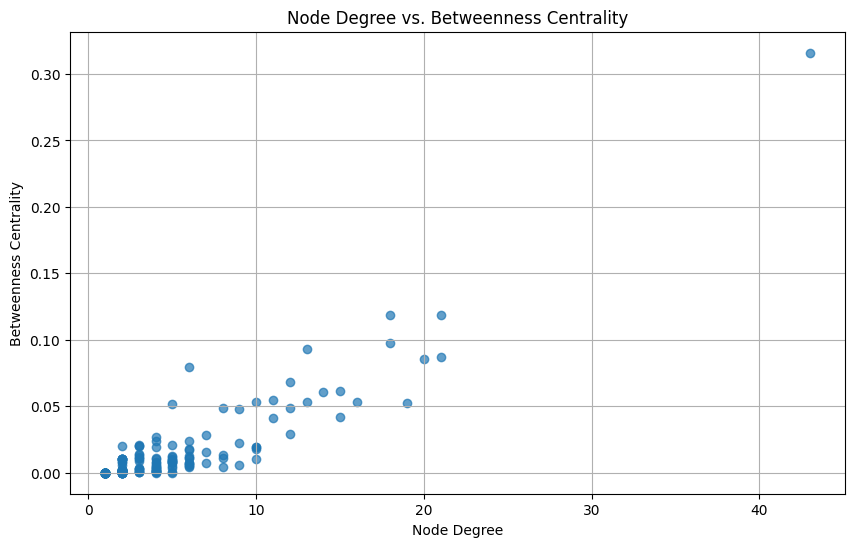

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(metrics_df['Degree'], metrics_df['Betweenness'], alpha=0.7)
plt.xlabel('Node Degree')
plt.ylabel('Betweenness Centrality')
plt.title('Node Degree vs. Betweenness Centrality')
plt.grid(True)
plt.show()

## 2. Comparative analysis of the disease genes identification algorithms

### 2.1 Use the following algorithms to infer and then validate (point 2.2) putative disease genes

##### Diamond

In [28]:
from DIAMOnD import DIAMOnD

In [29]:
# Ensure your seeds are in the form of a set
seed_genes = set(disease_genes_in_LCC)

In [30]:
# Parameters
max_number_of_added_nodes = 200  # Adjust as needed
alpha = 1  # Default value

# Run DIAMOnD with a valid outfile name
diamond_results = DIAMOnD(
    G_original=LCC,
    seed_genes=seed_genes,
    max_number_of_added_nodes=max_number_of_added_nodes,
    alpha=alpha,
    outfile='diamond_results.txt'  # Provide a valid filename
)

In [31]:
# Convert results to DataFrame
diamond_df = pd.DataFrame(diamond_results, columns=['Gene', 'Degree', 'Module_Neighbors', 'P-value'])

# Map Entrez IDs to Gene Symbols (assuming you have the mapping)
diamond_df['Gene Symbol'] = diamond_df['Gene'].map(entrez_to_gene_symbol)

# Rearrange columns
diamond_df = diamond_df[['Gene', 'Gene Symbol', 'Degree', 'Module_Neighbors', 'P-value']]

# Display the top 10 predicted genes
diamond_df.head(10)

,Gene,Gene Symbol,Degree,Module_Neighbors,P-value
0,2902,NaN,54,10,[1.8986787069168697e-09]
1,3320,NaN,1230,43,[4.544404113641784e-09]
2,5705,NaN,469,24,[1.880409275929173e-08]
3,6667,NaN,334,21,[4.666823048214055e-09]
4,1387,NaN,513,25,[2.8485971473557716e-08]
5,4193,NaN,620,28,[2.2356157468925892e-08]
6,5451,NaN,159,14,[3.396430799576877e-08]
7,11140,NaN,631,28,[3.808101524668903e-08]
8,6195,NaN,196,16,[1.156165840330179e-08]
9,3308,NaN,653,29,[2.4769405787450094e-08]


In [32]:
# Check the data type of Entrez IDs in diamond_df
print(f"Data type of Entrez IDs in diamond_df: {diamond_df['Gene'].dtype}")

# Check the data type of keys in entrez_to_gene_symbol
print(f"Data type of keys in entrez_to_gene_symbol: {type(list(entrez_to_gene_symbol.keys())[0])}")

Data type of Entrez IDs in diamond_df: int64
Data type of keys in entrez_to_gene_symbol: <class 'int'>


In [33]:
# Convert Entrez IDs to strings
diamond_df['Gene'] = diamond_df['Gene'].astype(str)
entrez_to_gene_symbol = {str(k): v for k, v in entrez_to_gene_symbol.items()}

In [34]:
# Find Entrez IDs not in mapping
missing_genes = diamond_df[~diamond_df['Gene'].isin(entrez_to_gene_symbol.keys())]['Gene'].unique()
print(f"Number of missing Entrez IDs: {len(missing_genes)}")

Number of missing Entrez IDs: 200


In [35]:
import mygene
mg = mygene.MyGeneInfo()

# Fetch gene symbols for missing Entrez IDs
query_results = mg.querymany(missing_genes, scopes='entrezgene', fields='symbol', species='human')

# Create a mapping from Entrez ID to Gene Symbol
missing_entrez_to_gene_symbol = {}
for item in query_results:
    if not item.get('notfound', False):
        missing_entrez_to_gene_symbol[item['query']] = item.get('symbol', '')
    else:
        print(f"Gene symbol not found for Entrez ID: {item['query']}")


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


In [36]:
# Update the main mapping
entrez_to_gene_symbol.update(missing_entrez_to_gene_symbol)

In [37]:
# Map Entrez IDs to Gene Symbols
diamond_df['Gene Symbol'] = diamond_df['Gene'].map(entrez_to_gene_symbol)

# Check for any remaining missing mappings
num_missing = diamond_df['Gene Symbol'].isna().sum()
print(f"Number of Entrez IDs still missing gene symbols: {num_missing}")

Number of Entrez IDs still missing gene symbols: 0


In [38]:
# Rearrange columns
diamond_df = diamond_df[['Gene', 'Gene Symbol', 'Degree', 'Module_Neighbors', 'P-value']]

# Display the top 10 predicted genes
diamond_df.head(10)

,Gene,Gene Symbol,Degree,Module_Neighbors,P-value
0,2902,GRIN1,54,10,[1.8986787069168697e-09]
1,3320,HSP90AA1,1230,43,[4.544404113641784e-09]
2,5705,PSMC5,469,24,[1.880409275929173e-08]
3,6667,SP1,334,21,[4.666823048214055e-09]
4,1387,CREBBP,513,25,[2.8485971473557716e-08]
5,4193,MDM2,620,28,[2.2356157468925892e-08]
6,5451,POU2F1,159,14,[3.396430799576877e-08]
7,11140,CDC37,631,28,[3.808101524668903e-08]
8,6195,RPS6KA1,196,16,[1.156165840330179e-08]
9,3308,HSPA4,653,29,[2.4769405787450094e-08]


In [39]:
# Ensure Entrez IDs are strings
diamond_df['Gene'] = diamond_df['Gene'].astype(str)
entrez_to_gene_symbol = {str(k): v for k, v in entrez_to_gene_symbol.items()}

# Identify missing Entrez IDs
missing_genes = diamond_df[~diamond_df['Gene'].isin(entrez_to_gene_symbol.keys())]['Gene'].unique()

# Fetch gene symbols for missing Entrez IDs
import mygene
mg = mygene.MyGeneInfo()
query_results = mg.querymany(missing_genes, scopes='entrezgene', fields='symbol', species='human')
missing_entrez_to_gene_symbol = {}
for item in query_results:
    if not item.get('notfound', False):
        missing_entrez_to_gene_symbol[item['query']] = item.get('symbol', '')
    else:
        print(f"Gene symbol not found for Entrez ID: {item['query']}")

# Update the mapping
entrez_to_gene_symbol.update(missing_entrez_to_gene_symbol)

# Map Entrez IDs to Gene Symbols
diamond_df['Gene Symbol'] = diamond_df['Gene'].map(entrez_to_gene_symbol)

# Verify the results
diamond_df = diamond_df[['Gene', 'Gene Symbol', 'Degree', 'Module_Neighbors', 'P-value']]
diamond_df.head(10)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


,Gene,Gene Symbol,Degree,Module_Neighbors,P-value
0,2902,GRIN1,54,10,[1.8986787069168697e-09]
1,3320,HSP90AA1,1230,43,[4.544404113641784e-09]
2,5705,PSMC5,469,24,[1.880409275929173e-08]
3,6667,SP1,334,21,[4.666823048214055e-09]
4,1387,CREBBP,513,25,[2.8485971473557716e-08]
5,4193,MDM2,620,28,[2.2356157468925892e-08]
6,5451,POU2F1,159,14,[3.396430799576877e-08]
7,11140,CDC37,631,28,[3.808101524668903e-08]
8,6195,RPS6KA1,196,16,[1.156165840330179e-08]
9,3308,HSPA4,653,29,[2.4769405787450094e-08]


##### Diable

In [40]:
from DiaBLE import DIAMOnD, read_input

In [41]:
# Ensure your seeds are in the form of a set:
seed_genes = set(disease_genes_in_LCC)

# Show some basic info
print(f"LCC has {LCC.number_of_nodes()} nodes, {LCC.number_of_edges()} edges.")
print(f"Number of disease seeds in LCC: {len(seed_genes)}")


LCC has 19974 nodes, 861240 edges.
Number of disease seeds in LCC: 263


In [42]:
# Parameters
max_number_of_added_nodes = 200  # or whichever number you want
alpha = 1                        # default seed weight
universe_size = 20000            # For example, treat 'universe' as 20,000 genes

# Run the algorithm
diamond_results = DIAMOnD(
    G_original=LCC,
    seed_genes=seed_genes,
    max_number_of_added_nodes=max_number_of_added_nodes,
    alpha=alpha,
    outfile='diamond_diable_results.txt',  # optional filename
    universe_size=universe_size            # the custom "universe size"
)

print(f"DiaBLE returned {len(diamond_results)} newly added nodes.")
diamond_results[:10]  # show the first 10


DiaBLE returned 200 newly added nodes.


[(2902, 54, 10, 1.875381732205837e-09),
 (3320, 1230, 43, 4.374104941914916e-09),
 (5705, 469, 24, 1.8351409489905693e-08),
 (6667, 334, 21, 4.563116402547383e-09),
 (1387, 513, 25, 2.7784069361611373e-08),
 (4193, 620, 28, 2.175568751684347e-08),
 (5451, 159, 14, 3.342701072085454e-08),
 (11140, 631, 28, 3.70675227839657e-08),
 (6195, 196, 16, 1.1355734426847547e-08),
 (3308, 653, 29, 2.4088368160386968e-08)]

In [43]:
diamond_df = pd.DataFrame(
    diamond_results,
    columns=['Gene', 'Degree', 'Module_Neighbors', 'P-value']
)
diamond_df.head(10)


,Gene,Degree,Module_Neighbors,P-value
0,2902,54,10,1.875382e-09
1,3320,1230,43,4.374105e-09
2,5705,469,24,1.835141e-08
3,6667,334,21,4.563116e-09
4,1387,513,25,2.778407e-08
5,4193,620,28,2.175569e-08
6,5451,159,14,3.342701e-08
7,11140,631,28,3.706752e-08
8,6195,196,16,1.135573e-08
9,3308,653,29,2.408837e-08


In [44]:
# Suppose you have a dictionary or function to map Entrez -> Symbol
# e.g. entrez_to_gene_symbol = {...} 
# or you might do the mygene approach from your screenshots

diamond_df['Gene Symbol'] = diamond_df['Gene'].map(entrez_to_gene_symbol)

# Rearrange columns
diamond_df = diamond_df[['Gene', 'Gene Symbol', 'Degree', 'Module_Neighbors', 'P-value']]

diamond_df.head(10)


,Gene,Gene Symbol,Degree,Module_Neighbors,P-value
0,2902,NaN,54,10,1.875382e-09
1,3320,NaN,1230,43,4.374105e-09
2,5705,NaN,469,24,1.835141e-08
3,6667,NaN,334,21,4.563116e-09
4,1387,NaN,513,25,2.778407e-08
5,4193,NaN,620,28,2.175569e-08
6,5451,NaN,159,14,3.342701e-08
7,11140,NaN,631,28,3.706752e-08
8,6195,NaN,196,16,1.135573e-08
9,3308,NaN,653,29,2.408837e-08


In [45]:
missing_genes = diamond_df[
    ~diamond_df['Gene'].isin(entrez_to_gene_symbol.keys())
]['Gene'].unique()

print(f"Number of missing Entrez IDs: {len(missing_genes)}")

Number of missing Entrez IDs: 200


In [46]:
import mygene
mg = mygene.MyGeneInfo()

query_results = mg.querymany(
    missing_genes, 
    scopes='entrezgene', 
    fields='symbol', 
    species='human'
)

# Build a dictionary for newly found mappings
missing_entrez_to_symbol = {}
for item in query_results:
    if not item.get('notfound', False):
        missing_entrez_to_symbol[item['query']] = item.get('symbol','')
    else:
        print(f"Gene symbol not found for Entrez ID: {item['query']}")

# Update your main mapping
entrez_to_gene_symbol.update(missing_entrez_to_symbol)

# Re-map
diamond_df['Gene Symbol'] = diamond_df['Gene'].map(entrez_to_gene_symbol)
num_missing = diamond_df['Gene Symbol'].isna().sum()
print(f"Number of Entrez IDs still missing gene symbols: {num_missing}")


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Number of Entrez IDs still missing gene symbols: 200


In [47]:
missing_genes


array([  2902,   3320,   5705,   6667,   1387,   4193,   5451,  11140,
         6195,   3308,   9063,   5241,   5594,   3725,   1386,   3091,
         8850,    408,   6714,  10273,   6256,    602,   8841,   7189,
         1147,   3551,   4296,   8202,   5914,   8648,   4088,   7421,
         5970,   2033,   2353,    860,   9611,   2113,   4790,   9612,
        23054,   5468,  10524,  23411,   2101,   8431,  10062,  10499,
         8856,  10891,   9971,   7329,   3172,   9970,   9759,   5467,
         7376,  29947,   6772,   5465,   8204,   6258,   7068,   5591,
         7067,    595,    405,   7157,   4792,   1869,   5925,   2309,
         1487,   1026,   8554,   7161,   3065,   6670,   6908,   4261,
         1499,   4800,   4801,    983,   2547,   1457,   5371,   6996,
         6597,   3164,   3315,   7520,   4772,    472,   7428,   2034,
        51341,   5469,    196,    142,   6722,   3159,   1050,   7704,
         7341,   4780,   7020,   1786,   6502,   8517,   1019,   4089,
      

In [48]:
import mygene
mg = mygene.MyGeneInfo()

# 1) Convert to string
diamond_df['Gene'] = diamond_df['Gene'].astype(str)

# 2) Identify missing genes relative to our mapping dictionary
missing_genes = diamond_df[
    ~diamond_df['Gene'].isin(entrez_to_gene_symbol.keys())
]['Gene'].unique()

print(f"Number of missing Entrez IDs: {len(missing_genes)}")

# 3) Attempt multiple scopes
query_results = mg.querymany(
    missing_genes,
    scopes=['entrezgene','ensembl.gene','symbol','alias'],
    fields='symbol',
    species='human'
)

missing_entrez_to_symbol = {}
for item in query_results:
    q = item['query']
    if not item.get('notfound', False):
        # item['symbol'] might be None; fallback to empty
        missing_entrez_to_symbol[q] = item.get('symbol','')
    else:
        print(f"Gene symbol not found for: {q}")

# 4) Update your main dict
entrez_to_gene_symbol.update(missing_entrez_to_symbol)

# 5) Remap
diamond_df['Gene Symbol'] = diamond_df['Gene'].map(entrez_to_gene_symbol)
num_missing = diamond_df['Gene Symbol'].isna().sum()
print(f"Number of Entrez IDs still missing gene symbols: {num_missing}")

diamond_df.head(10)


Input sequence provided is already in string format. No operation performed


Number of missing Entrez IDs: 0
Number of Entrez IDs still missing gene symbols: 0


,Gene,Gene Symbol,Degree,Module_Neighbors,P-value
0,2902,GRIN1,54,10,1.875382e-09
1,3320,HSP90AA1,1230,43,4.374105e-09
2,5705,PSMC5,469,24,1.835141e-08
3,6667,SP1,334,21,4.563116e-09
4,1387,CREBBP,513,25,2.778407e-08
5,4193,MDM2,620,28,2.175569e-08
6,5451,POU2F1,159,14,3.342701e-08
7,11140,CDC37,631,28,3.706752e-08
8,6195,RPS6KA1,196,16,1.135573e-08
9,3308,HSPA4,653,29,2.408837e-08


##### Diffusion-based algorithm

In [49]:
def diffusion_pagerank(G, seed_genes, alpha=0.85):
    """
    G: a networkx Graph
    seed_genes: set/list of seed nodes (Entrez IDs) that are 'activated'
    alpha: PageRank damping factor
    Returns: List of (node, diffusion_score) sorted descending
    """
    personalization = {
        node: 1.0 if node in seed_genes else 0.0
        for node in G.nodes()
    }
    pagerank_scores = nx.pagerank(G, alpha=alpha, personalization=personalization)
    # Sort descending by score
    sorted_scores = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_scores

# Example usage for each time:
time_values = [0.002, 0.005, 0.01]
all_diffusion_results = {}

for t in time_values:
    alpha = 1.0 - t
    diffusion_scores = diffusion_pagerank(LCC, seed_genes, alpha=alpha)
    df_diff = pd.DataFrame(diffusion_scores, columns=["Gene", "Diffusion_Score"])

    # Convert to string if your dictionary has string keys
    df_diff["Gene"] = df_diff["Gene"].astype(str)

    # Map to gene symbols
    df_diff["Gene Symbol"] = df_diff["Gene"].map(entrez_to_gene_symbol)

    # (Optional) If you want to fill in top hits:
    top_50_missing = df_diff.head(50)[df_diff["Gene Symbol"].isna()]["Gene"].unique()
    # Then do MyGene queries on these top 50 to fill them in
    # ...
    
    all_diffusion_results[t] = df_diff

# Now we have a separate DataFrame for t=0.002, 0.005, and 0.01 in `all_diffusion_results[t]`
  

In [50]:
df_diff.sort_values("Diffusion_Score", ascending=False, inplace=True)

In [51]:
df_diff

,Gene,Diffusion_Score,Gene Symbol
0,440730,2.757031e-03,NaN
1,54764,2.347002e-03,NaN
2,5071,1.939189e-03,NaN
3,6117,1.702858e-03,NaN
4,25962,1.664065e-03,NaN
...,...,...,...
19969,137814,5.192418e-07,NaN
19970,116511,5.182661e-07,NaN
19971,259285,5.174326e-07,NaN
19972,343641,5.160771e-07,NaN


In [52]:
top_100_genes = df_diff.head(100)["Gene"].unique()
missing_top_100 = [g for g in top_100_genes if g not in entrez_to_gene_symbol]

In [53]:
query_results = mg.querymany(
    missing_top_100,
    scopes=['entrezgene','ensembl.gene','alias','retired'],
    fields='symbol',
    species='human'
)
# Build a small dictionary for these hits
missing_map = {}
for item in query_results:
    if not item.get("notfound", False):
        missing_map[item["query"]] = item["symbol"]
# Update your main dictionary
entrez_to_gene_symbol.update(missing_map)
# Re-map
df_diff["Gene Symbol"] = df_diff["Gene"].map(entrez_to_gene_symbol)

Input sequence provided is already in string format. No operation performed


In [54]:
df_diff

,Gene,Diffusion_Score,Gene Symbol
0,440730,2.757031e-03,TRIM67
1,54764,2.347002e-03,ZRANB1
2,5071,1.939189e-03,PRKN
3,6117,1.702858e-03,RPA1
4,25962,1.664065e-03,VIRMA
...,...,...,...
19969,137814,5.192418e-07,NaN
19970,116511,5.182661e-07,NaN
19971,259285,5.174326e-07,NaN
19972,343641,5.160771e-07,NaN


### 2.2 Computational validation


In [55]:
# Suppose you already have:
# LCC: a NetworkX graph of the human interactome
# disease_gene_list: list of known disease Entrez IDs in LCC (the set S0)

S0 = list(disease_genes_in_LCC)  # ensure it's a list
print(f"Number of known disease genes (S0): {len(S0)}")

Number of known disease genes (S0): 263


In [56]:
def compute_metrics_at_k(ranked_list, probe_genes, k):
    """
    ranked_list: a list of nodes in descending order of 'predicted relevance'
    probe_genes: the withheld disease genes for testing (S_P)
    k: the cutoff (top K)

    Returns (precision, recall, f1) at top k
    """
    top_k_genes = set(ranked_list[:k])  # the first k genes

    # Count how many probe_genes appear in the top K
    correct_preds = top_k_genes.intersection(probe_genes)

    precision_k = len(correct_preds) / k
    recall_k = len(correct_preds) / len(probe_genes) if len(probe_genes) > 0 else 0.0

    if (precision_k + recall_k) == 0:
        f1_k = 0.0
    else:
        f1_k = 2 * (precision_k * recall_k) / (precision_k + recall_k)

    return precision_k, recall_k, f1_k


In [57]:
import csv
from statistics import mean, stdev
from sklearn.model_selection import KFold

# Define time values and corresponding alpha values
time_values = [0.002, 0.005, 0.01]
alpha_values = [1.0 - t for t in time_values]

# Results storage
results = []
best_t_value = None
best_f1_score = -1

# Perform K-fold cross-validation for each alpha
for t, alpha in zip(time_values, alpha_values):
    print(f"\n=== Evaluating t = {t} (alpha = {alpha}) ===")
    all_precisions_50 = []
    all_recalls_50 = []
    all_f1_50 = []

    fold_index = 1
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(S0):
        # 1) Split the disease genes
        S_T = [S0[i] for i in train_index]  # training seeds
        S_P = [S0[i] for i in test_index]   # probe set (withheld genes)
        
        print(f"\nFold {fold_index}: Training size: {len(S_T)}, Probe size: {len(S_P)}")

        # 2) Run diffusion with S_T as seeds
        diffusion_scores = diffusion_pagerank(LCC, seed_genes=S_T, alpha=alpha)

        # 3) Remove the training seeds from the ranked list
        ranked_nodes = [n for (n, scr) in diffusion_scores]
        ranked_nodes_no_seeds = [g for g in ranked_nodes if g not in S_T]

        # 4) Evaluate metrics for top 50
        if len(ranked_nodes_no_seeds) >= 50:
            precision_k, recall_k, f1_k = compute_metrics_at_k(
                ranked_nodes_no_seeds, set(S_P), 50
            )
            all_precisions_50.append(precision_k)
            all_recalls_50.append(recall_k)
            all_f1_50.append(f1_k)

            print(f"Top 50 => Precision={precision_k:.5f}, Recall={recall_k:.5f}, F1={f1_k:.5f}")
        
        fold_index += 1

    # Compute average and standard deviation
    avg_prec = mean(all_precisions_50)
    std_prec = stdev(all_precisions_50)
    avg_rec = mean(all_recalls_50)
    std_rec = stdev(all_recalls_50)
    avg_f1 = mean(all_f1_50)
    std_f1 = stdev(all_f1_50)

    print(f"\n=== Results for t = {t} ===")
    print(f"Precision: {avg_prec:.5f} ± {std_prec:.5f}")
    print(f"Recall: {avg_rec:.5f} ± {std_rec:.5f}")
    print(f"F1: {avg_f1:.5f} ± {std_f1:.5f}")

    # Store results
    results.append({
        "t_value": t,
        "alpha": alpha,
        "avg_precision": avg_prec,
        "std_precision": std_prec,
        "avg_recall": avg_rec,
        "std_recall": std_rec,
        "avg_f1": avg_f1,
        "std_f1": std_f1
    })

    # Update best t value
    if avg_f1 > best_f1_score:
        best_f1_score = avg_f1
        best_t_value = t

# Save results to CSV
output_csv = "cross_validation_results.csv"
with open(output_csv, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print(f"\nResults saved to {output_csv}")

# Print the best t value
print(f"\n=== Best t value ===")
print(f"t = {best_t_value}, with F1 = {best_f1_score:.5f}")



=== Evaluating t = 0.002 (alpha = 0.998) ===

Fold 1: Training size: 210, Probe size: 53
Top 50 => Precision=0.02000, Recall=0.01887, F1=0.01942

Fold 2: Training size: 210, Probe size: 53
Top 50 => Precision=0.02000, Recall=0.01887, F1=0.01942

Fold 3: Training size: 210, Probe size: 53
Top 50 => Precision=0.00000, Recall=0.00000, F1=0.00000

Fold 4: Training size: 211, Probe size: 52
Top 50 => Precision=0.00000, Recall=0.00000, F1=0.00000

Fold 5: Training size: 211, Probe size: 52
Top 50 => Precision=0.00000, Recall=0.00000, F1=0.00000

=== Results for t = 0.002 ===
Precision: 0.00800 ± 0.01095
Recall: 0.00755 ± 0.01033
F1: 0.00777 ± 0.01064

=== Evaluating t = 0.005 (alpha = 0.995) ===

Fold 1: Training size: 210, Probe size: 53
Top 50 => Precision=0.02000, Recall=0.01887, F1=0.01942

Fold 2: Training size: 210, Probe size: 53
Top 50 => Precision=0.02000, Recall=0.01887, F1=0.01942

Fold 3: Training size: 210, Probe size: 53
Top 50 => Precision=0.00000, Recall=0.00000, F1=0.00000


In [ ]:
missing_in_graph = [g for g in S_P if g not in LCC.nodes()]
print(len(missing_in_graph))

In [58]:
from DIAMOnD import DIAMOnD as DIAMOND_alg
from DiaBLE import DIAMOnD  as DIABLE_alg

In [59]:
# Convert the known disease genes to a list for KFold
S0 = list(disease_genes_in_LCC)

# We'll do 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# We only evaluate top 50 (just like your diffusion example)
cutoff = 50

# Prepare data structures to store metrics for each algorithm
diamond_metrics_50 = {'precision': [], 'recall': [], 'f1': []}
diable_metrics_50  = {'precision': [], 'recall': [], 'f1': []}

def compute_metrics_at_k(ranked_list, probe_genes, k):
    """
    Exactly the same approach you used for diffusion:
    ranked_list: list of newly predicted genes in order of ascending p-value.
    probe_genes: withheld disease genes (S_P).
    k:           top K cutoff.

    Returns (precision, recall, f1).
    """
    top_k = set(ranked_list[:k])
    correct = top_k.intersection(probe_genes)

    precision_k = len(correct) / k
    recall_k    = 0.0 if len(probe_genes) == 0 else len(correct) / len(probe_genes)
    if (precision_k + recall_k) == 0:
        f1_k = 0.0
    else:
        f1_k = 2.0 * (precision_k * recall_k) / (precision_k + recall_k)

    return precision_k, recall_k, f1_k

fold_index = 1
for train_index, test_index in kf.split(S0):
    S_T = [S0[i] for i in train_index]  # training seeds
    S_P = [S0[i] for i in test_index]   # withheld (probe)

    print(f"\n=== FOLD {fold_index} ===")
    print(f"Train size: {len(S_T)}, Probe size: {len(S_P)}")

    ################################################################
    # 1) Run the "standard" DIAMOnD from DIAMOnD.py
    ################################################################
    # We give each fold a unique output file to avoid 'NoneType' error.
    diamond_outfile = f"diamond_fold_{fold_index}.txt"

    diamond_results = DIAMOND_alg(
        G_original=LCC,
        seed_genes=set(S_T),
        max_number_of_added_nodes=200,
        alpha=1,
        outfile=diamond_outfile  # Must be a real filename or you'll get a TypeError
    )
    # diamond_results is typically: [(node, k, kb, p), ...]
    # Sort them by ascending p-value => index [3]
    diamond_sorted = sorted(diamond_results, key=lambda x: x[3])
    diamond_ranked = [str(item[0]) for item in diamond_sorted]

    # Remove training seeds from the final ranking
    diamond_no_seeds = [g for g in diamond_ranked if g not in S_T]

    # Evaluate at top 50
    p_k, r_k, f1_k = compute_metrics_at_k(diamond_no_seeds, set(S_P), cutoff)
    diamond_metrics_50['precision'].append(p_k)
    diamond_metrics_50['recall'].append(r_k)
    diamond_metrics_50['f1'].append(f1_k)

    print(f"[DIAMOND] top {cutoff} => P={p_k:.3f}, R={r_k:.3f}, F1={f1_k:.3f}")


    ################################################################
    # 2) Run DiaBLE from DiaBLE.py (with custom universe_size)
    ################################################################
    diable_outfile = f"diable_fold_{fold_index}.txt"

    diable_results = DIABLE_alg(
        G_original=LCC,
        seed_genes=set(S_T),
        max_number_of_added_nodes=200,
        alpha=1,
        outfile=diable_outfile,
        universe_size=20000  # Example custom size for DiaBLE
    )
    diable_sorted = sorted(diable_results, key=lambda x: x[3])
    diable_ranked = [str(item[0]) for item in diable_sorted]

    diable_no_seeds = [g for g in diable_ranked if g not in S_T]

    p_k, r_k, f1_k = compute_metrics_at_k(diable_no_seeds, set(S_P), cutoff)
    diable_metrics_50['precision'].append(p_k)
    diable_metrics_50['recall'].append(r_k)
    diable_metrics_50['f1'].append(f1_k)

    print(f"[DiaBLE ] top {cutoff} => P={p_k:.3f}, R={r_k:.3f}, F1={f1_k:.3f}")

    fold_index += 1

##############################################
# 3) Summarize results over 5 folds
##############################################
print("\n=== 5-Fold CV Results (DIAMOND) @ top 50 ===")
p_vals = diamond_metrics_50['precision']
r_vals = diamond_metrics_50['recall']
f_vals = diamond_metrics_50['f1']
print(f"Precision: {mean(p_vals):.3f} ± {stdev(p_vals):.3f}")
print(f"Recall:    {mean(r_vals):.3f} ± {stdev(r_vals):.3f}")
print(f"F1:        {mean(f_vals):.3f} ± {stdev(f_vals):.3f}")

print("\n=== 5-Fold CV Results (DiaBLE) @ top 50 ===")
p_vals = diable_metrics_50['precision']
r_vals = diable_metrics_50['recall']
f_vals = diable_metrics_50['f1']
print(f"Precision: {mean(p_vals):.3f} ± {stdev(p_vals):.3f}")
print(f"Recall:    {mean(r_vals):.3f} ± {stdev(r_vals):.3f}")
print(f"F1:        {mean(f_vals):.3f} ± {stdev(f_vals):.3f}")



=== FOLD 1 ===
Train size: 210, Probe size: 53
[DIAMOND] top 50 => P=0.000, R=0.000, F1=0.000
[DiaBLE ] top 50 => P=0.000, R=0.000, F1=0.000

=== FOLD 2 ===
Train size: 210, Probe size: 53
[DIAMOND] top 50 => P=0.000, R=0.000, F1=0.000
[DiaBLE ] top 50 => P=0.000, R=0.000, F1=0.000

=== FOLD 3 ===
Train size: 210, Probe size: 53
[DIAMOND] top 50 => P=0.000, R=0.000, F1=0.000
[DiaBLE ] top 50 => P=0.000, R=0.000, F1=0.000

=== FOLD 4 ===
Train size: 211, Probe size: 52
[DIAMOND] top 50 => P=0.000, R=0.000, F1=0.000
[DiaBLE ] top 50 => P=0.000, R=0.000, F1=0.000

=== FOLD 5 ===
Train size: 211, Probe size: 52
[DIAMOND] top 50 => P=0.000, R=0.000, F1=0.000
[DiaBLE ] top 50 => P=0.000, R=0.000, F1=0.000

=== 5-Fold CV Results (DIAMOND) @ top 50 ===
Precision: 0.000 ± 0.000
Recall:    0.000 ± 0.000
F1:        0.000 ± 0.000

=== 5-Fold CV Results (DiaBLE) @ top 50 ===
Precision: 0.000 ± 0.000
Recall:    0.000 ± 0.000
F1:        0.000 ± 0.000


## 3. Putative disease gene identification

### 3.1 According to the performance metrics obtained in the validation phase at point 2:


In [60]:
import networkx as nx

def diffusion_pagerank(G, seed_genes, alpha=0.85):
    """
    Simple personalized PageRank diffusion:
      - G:        networkx Graph
      - seed_genes: a set/list of seeds with 'heat' = 1
      - alpha:    PageRank damping factor
    Returns:
      A list of (node, diffusion_score), sorted descending by score
    """
    personalization = {n: 0.0 for n in G.nodes()}
    for s in seed_genes:
        personalization[s] = 1.0
    
    # Run Personalized PageRank
    pr_scores = nx.pagerank(G, alpha=alpha, personalization=personalization)
    
    # Sort by descending score
    sorted_scores = sorted(pr_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_scores

# 1) All disease genes as seeds
all_seeds = set(disease_genes_in_LCC)  # e.g. ~263 genes

# 2) Run diffusion with best_t_value (or whatever you used in cross-validation)
alpha_val = 1-best_t_value
ranked_scores = diffusion_pagerank(LCC, seed_genes=all_seeds, alpha=alpha_val)

# 'ranked_scores' is a list of (node, score), highest score first
# 3) Convert to just node order
ranked_nodes = [n for (n, score) in ranked_scores]

# 4) Remove the seed genes from that ranking
ranked_candidates = [node for node in ranked_nodes if node not in all_seeds]

# 5) Take top 100
putative_disease_genes = ranked_candidates[:100]

print("Top 100 putative disease genes (Diffusion-based):")
for i, gene in enumerate(putative_disease_genes, start=1):
    print(f"{i}. {gene}")


Top 100 putative disease genes (Diffusion-based):
1. 440730
2. 54764
3. 5071
4. 6117
5. 57664
6. 25962
7. 4609
8. 6118
9. 6119
10. 8452
11. 7706
12. 2100
13. 7157
14. 3312
15. 899
16. 1994
17. 4914
18. 3191
19. 7328
20. 8872
21. 5894
22. 23586
23. 9928
24. 1956
25. 54443
26. 8359
27. 7316
28. 10618
29. 23476
30. 3187
31. 3303
32. 3309
33. 25976
34. 8940
35. 6780
36. 1080
37. 7514
38. 2146
39. 10155
40. 6047
41. 26135
42. 9343
43. 1051
44. 11113
45. 7415
46. 9401
47. 7182
48. 6657
49. 10482
50. 4613
51. 2033
52. 203228
53. 330
54. 112399
55. 998
56. 4343
57. 821
58. 142
59. 4000
60. 8314
61. 328
62. 3320
63. 4204
64. 65992
65. 8878
66. 10318
67. 7534
68. 387
69. 7532
70. 1050
71. 7531
72. 3845
73. 10212
74. 4869
75. 55054
76. 51343
77. 59272
78. 5245
79. 10971
80. 10413
81. 51574
82. 10987
83. 7533
84. 11091
85. 3065
86. 10075
87. 4171
88. 10112
89. 23376
90. 832
91. 9584
92. 9493
93. 4221
94. 3329
95. 7529
96. 60
97. 23137
98. 55716
99. 79829
100. 25831


In [61]:
import csv

with open("PutativeDiseaseGenes.csv", "w", newline="") as fout:
    writer = csv.writer(fout)
    writer.writerow(["Rank", "Gene"])
    for i, gene in enumerate(putative_disease_genes, start=1):
        writer.writerow([i, gene])

### 3.2 Enrichment analysis

In [62]:
import gseapy as gp

#############################################
# 1) READ ORIGINAL DISEASE GENES
#############################################
df_orig = pd.read_csv("Verified_GDAs.tsv", sep="\t")
original_gene_list = df_orig["Gene"].dropna().unique().tolist()
print(f"Loaded {len(original_gene_list)} original disease genes")

#############################################
# 2) READ PUTATIVE DISEASE GENES
#############################################
df_put = pd.read_csv("PutativeDiseaseGenes.csv")
putative_gene_list = df_put["Gene"].dropna().unique().tolist()
# Convert any integer IDs to string
putative_gene_list = [str(g) for g in putative_gene_list]
print(f"Loaded {len(putative_gene_list)} putative disease genes (converted to strings)")

#############################################
# 3) DEFINE THE LIBRARIES
#############################################
libs = [
    "GO_Biological_Process_2021",
    "GO_Molecular_Function_2021",
    "GO_Cellular_Component_2021",
    "Reactome_2022",
    "KEGG_2021_Human"
]

#############################################
# 4) ENRICHMENT FUNCTION
#############################################
def run_enrichr(gene_list, label):
    """
    Run Enrichr via gseapy. 
    Returns a single DataFrame with all libraries combined,
    labeled in the 'Gene_set' column.
    """
    outdir = os.path.join("enrichr_results", label)
    os.makedirs(outdir, exist_ok=True)

    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets=libs,
        organism='Human',
        outdir=outdir,
        cutoff=0.05,
        no_plot=True  # Avoid ValueError if no terms < 0.05
    )
    # enr.results is a Pandas DataFrame containing all results merged
    return enr.results

#############################################
# 5) RUN ENRICHMENT
#############################################
orig_res = run_enrichr(original_gene_list, "original_genes")
put_res  = run_enrichr(putative_gene_list, "putative_genes")

print("\n=== Enrichment result for original genes => orig_res")
print(orig_res.head(3))

print("\n=== Enrichment result for putative genes => put_res")
print(put_res.head(3))

#############################################
# 6) FUNCTION TO SHOW TOP TERMS PER LIBRARY
#############################################
def show_top_significant(df, gene_set_name, alpha=0.05, top=5):
    """
    Filters df for rows where Gene_set == gene_set_name 
    and Adjusted P-value < alpha, then prints top N.
    """
    df_filt = df[df["Gene_set"] == gene_set_name].copy()
    df_sig = df_filt[df_filt["Adjusted P-value"] < alpha]
    df_sig.sort_values("Adjusted P-value", inplace=True)
    print(f"\n=== {gene_set_name}: {len(df_sig)} terms with p<{alpha} ===")
    if len(df_sig) == 0:
        return
    display_cols = ["Term","Adjusted P-value","Overlap","Combined Score"]
    print(df_sig[display_cols].head(top))


Loaded 271 original disease genes
Loaded 100 putative disease genes (converted to strings)

=== Enrichment result for original genes => orig_res
                     Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   

                                                Term Overlap       P-value  \
0        chemical synaptic transmission (GO:0007268)  52/306  5.829185e-42   
1  anterograde trans-synaptic signaling (GO:0098916)  46/244  3.034567e-39   
2  adenylate cyclase-inhibiting G protein-coupled...   17/60  2.429095e-18   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      1.645579e-38            0                     0   18.205515   
1      4.283291e-36            0                     0   20.166689   
2      2.285779e-15            0                     0   30.641091   

   Combined Score                                              Genes  
0     1728.535343  GABRB3;CHRM2;SNAP25;GRIK3;HTR2C;DBH;HT

In [63]:
#############################################
# 7) EXAMPLES: Print top 5 for GO_Biological_Process_2021
#############################################
show_top_significant(orig_res, "GO_Biological_Process_2021", alpha=0.05, top=20)
show_top_significant(put_res, "GO_Biological_Process_2021", alpha=0.05, top=20)


=== GO_Biological_Process_2021: 915 terms with p<0.05 ===
                                                 Term  Adjusted P-value  \
0         chemical synaptic transmission (GO:0007268)      1.645579e-38   
1   anterograde trans-synaptic signaling (GO:0098916)      4.283291e-36   
2   adenylate cyclase-inhibiting G protein-coupled...      2.285779e-15   
3   positive regulation of macromolecule metabolic...      1.885693e-14   
4   G protein-coupled receptor signaling pathway, ...      1.672977e-13   
5   modulation of chemical synaptic transmission (...      2.154657e-13   
6   phospholipase C-activating G protein-coupled r...      2.521825e-13   
7   negative regulation of inflammatory response (...      5.477019e-13   
8   cellular response to organic cyclic compound (...      5.090831e-12   
9   positive regulation of gene expression (GO:001...      3.432546e-11   
10  regulation of NMDA receptor activity (GO:2000310)      5.938629e-11   
11  negative regulation of inflammatory r

In [64]:
show_top_significant(orig_res, "GO_Molecular_Function_2021", alpha=0.05, top=20)
show_top_significant(put_res, "GO_Molecular_Function_2021", alpha=0.05, top=20)


=== GO_Molecular_Function_2021: 113 terms with p<0.05 ===
                                                   Term  Adjusted P-value  \
2823                      hormone activity (GO:0005179)      1.377320e-13   
2824              receptor ligand activity (GO:0048018)      3.035714e-12   
2825         neuropeptide hormone activity (GO:0005184)      1.124352e-10   
2826   G protein-coupled receptor activity (GO:0004930)      5.306031e-09   
2827  G protein-coupled amine receptor activity (GO:...      6.915422e-09   
2828                growth factor activity (GO:0008083)      1.112481e-08   
2829  postsynaptic neurotransmitter receptor activit...      1.112481e-08   
2830           serotonin receptor activity (GO:0099589)      1.891174e-08   
2831  G protein-coupled serotonin receptor activity ...      1.891174e-08   
2832    sodium:chloride symporter activity (GO:0015378)      2.067989e-08   
2833  ligand-gated cation channel activity (GO:0099094)      4.183936e-07   
2834  G protein-c

In [65]:
show_top_significant(orig_res, "GO_Cellular_Component_2021", alpha=0.05, top=20)
show_top_significant(put_res, "GO_Cellular_Component_2021", alpha=0.05, top=20)


=== GO_Cellular_Component_2021: 41 terms with p<0.05 ===
                                                   Term  Adjusted P-value  \
3258                     neuron projection (GO:0043005)      1.421712e-46   
3259                              dendrite (GO:0030425)      7.106930e-28   
3260  integral component of plasma membrane (GO:0005...      3.900594e-25   
3261                                  axon (GO:0030424)      3.306206e-13   
3262                    asymmetric synapse (GO:0032279)      1.282829e-06   
3263                  postsynaptic density (GO:0014069)      1.314513e-05   
3264                cation channel complex (GO:0034703)      1.718795e-05   
3265  ionotropic glutamate receptor complex (GO:0008...      9.669923e-05   
3266                         membrane raft (GO:0045121)      3.128237e-04   
3268         postsynaptic density membrane (GO:0098839)      2.398704e-03   
3267              neuron to neuron synapse (GO:0098984)      2.398704e-03   
3269              

In [66]:
show_top_significant(orig_res, "Reactome_2022", alpha=0.05, top=20)
show_top_significant(put_res, "Reactome_2022", alpha=0.05, top=20)


=== Reactome_2022: 291 terms with p<0.05 ===
                                                   Term  Adjusted P-value  \
3454                     Signaling By GPCR R-HSA-372790      1.889315e-37   
3455                   Signal Transduction R-HSA-162582      4.971810e-37   
3456             GPCR Downstream Signaling R-HSA-388396      9.972499e-36   
3457                   GPCR Ligand Binding R-HSA-500792      1.424389e-30   
3458  Class A/1 (Rhodopsin-like Receptors) R-HSA-373076      1.195250e-27   
3459  Transmission Across Chemical Synapses R-HSA-11...      1.328800e-24   
3460                       Neuronal System R-HSA-112316      9.454865e-23   
3461          G Alpha (I) Signaling Events R-HSA-418594      4.856621e-19   
3462      Peptide Ligand-Binding Receptors R-HSA-375276      1.310671e-17   
3463        Amine Ligand-Binding Receptors R-HSA-375280      1.586727e-16   
3464          G Alpha (S) Signaling Events R-HSA-418555      1.105068e-14   
3465  Interleukin-4 And Interl

In [67]:
show_top_significant(orig_res, "KEGG_2021_Human", alpha=0.05, top=20)
show_top_significant(put_res, "KEGG_2021_Human", alpha=0.05, top=20)


=== KEGG_2021_Human: 172 terms with p<0.05 ===
                                                   Term  Adjusted P-value  \
4281            Neuroactive ligand-receptor interaction      2.362641e-52   
4282                               Dopaminergic synapse      2.909938e-26   
4283                             cAMP signaling pathway      1.179359e-25   
4284                               Serotonergic synapse      1.865774e-24   
4285                              Amphetamine addiction      6.912131e-20   
4286                          Calcium signaling pathway      8.959441e-19   
4287                                  Cocaine addiction      1.676092e-18   
4288                                         Alcoholism      1.497399e-17   
4289                      Pathways of neurodegeneration      1.973280e-16   
4290                             MAPK signaling pathway      1.438916e-14   
4291                              Glutamatergic synapse      2.502535e-14   
4292                        

## 4. Drug repurposing

In [68]:
import mygene

# Initialize MyGeneInfo
mg = mygene.MyGeneInfo()

# Corrected the `top20` list to properly separate integers with commas
top20 = pd.read_csv('PutativeDiseaseGenes.csv')['Gene'].iloc[:20].to_list()

# Query MyGeneInfo API
res = mg.querymany(top20, scopes='entrezgene', fields='symbol', species='human')

# Process and print results
for item in res:
    print(f"{item['query']} -> {item.get('symbol')} notfound? {item.get('notfound')}")


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


440730 -> TRIM67 notfound? None
54764 -> ZRANB1 notfound? None
5071 -> PRKN notfound? None
6117 -> RPA1 notfound? None
57664 -> PLEKHA4 notfound? None
25962 -> VIRMA notfound? None
4609 -> MYC notfound? None
6118 -> RPA2 notfound? None
6119 -> RPA3 notfound? None
8452 -> CUL3 notfound? None
7706 -> TRIM25 notfound? None
2100 -> ESR2 notfound? None
7157 -> TP53 notfound? None
3312 -> HSPA8 notfound? None
899 -> CCNF notfound? None
1994 -> ELAVL1 notfound? None
4914 -> NTRK1 notfound? None
3191 -> HNRNPL notfound? None
7328 -> UBE2H notfound? None
8872 -> CDC123 notfound? None


In [69]:
df_dgidb = pd.read_csv("interactions.tsv", sep="\t")
# often has columns like gene_name, drug_name, approved, interaction_types, ...

In [70]:
top20_symbols = [
    "TRIM67", "ZRANB1", "PRKN", "RPA1", "PLEKHA4", 
    "VIRMA", "MYC", "RPA2", "RPA3", "CUL3", 
    "TRIM25", "ESR2", "TP53", "HSPA8", "CCNF", 
    "ELAVL1", "NTRK1", "HNRNPL", "UBE2H", "CDC123"
]

sub = df_dgidb[
    (df_dgidb["gene_name"].isin(top20_symbols)) &
    (df_dgidb["approved"] == True)
]

In [71]:
drug_counts = sub.groupby("drug_name")["gene_name"].nunique().reset_index()
drug_counts.columns = ["drug_name", "count_of_genes"]
drug_counts.sort_values("count_of_genes", ascending=False, inplace=True)
print(drug_counts.head(20))

                      drug_name  count_of_genes
61           DIETHYLSTILBESTROL               3
195                   TAMOXIFEN               3
45                    CISPLATIN               3
148                    OLAPARIB               3
63          DOCETAXEL ANHYDROUS               2
35                 CAPIVASERTIB               2
189                   SORAFENIB               2
179                   RITUXIMAB               2
52                   CRIZOTINIB               2
54   CYCLOPHOSPHAMIDE ANHYDROUS               2
56                   CYTARABINE               2
60                DEXAMETHASONE               2
173    RALOXIFENE HYDROCHLORIDE               2
77           ESTRADIOL VALERATE               2
26                    BITHIONOL               2
84                      ESTRONE               2
153                 PALBOCICLIB               2
96                  FULVESTRANT               2
98                  GEMCITABINE               2
99                    GENISTEIN         